### Discrete Fourier Transform

The [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) $\mathcal{F}: \mathbb{C}^n \rightarrow \mathbb{C}^n$ maps a vector of complex numbers $x_n = (x_0, x_1, \dots, x_{n - 1})$ into a vector of complex numbers $X_n = (X_0, X_1, \dots, X_{n - 1})$:
\\[ X_k = \sum_{j = 0}^{n - 1} x_j \exp{\left(-\frac{2\pi i}{n} kj\right)} = \sum_{j = 0}^{n - 1} x_j \left[\cos\left(\frac{2\pi kj}{n} \right) - i \sin\left(\frac{2\pi kj}{n} \right)  \right].\\]

The discrete Fourier transform is an invertible, linear transformation whose inverse transform is given by
\\[ x_j = \frac{1}{n}\sum_{k = 0}^{n - 1} X_k \exp{\left(\frac{2\pi i}{n} kj\right)}.\\]

The linear transformation is completely defined by the DFT matrix $F_n$ where $\omega_{ij} = (\omega^{jk})/\sqrt{n}$ and $\omega = e^{-2\pi i / n}$ is a primitive $n$-th root of unity in which $i^2 = -1$:
\\[ F_{n} = \begin{bmatrix}1 & 1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega^2 & \omega^3 & \dots & \omega^{n - 1} \\ 1 & \omega^2 & \omega^4 & \omega^6 & \dots & \omega^{2(n - 1)} \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega^{n - 1} & \omega^{2(n - 1)} & \omega^{3(n - 1)} & \dots &  \omega^{(n - 1)(n - 1)} \end{bmatrix} \\]

Notably, the columns of $F_n$ form an orthogonal basis over the set of $n$-dimensional complex vectors. In case of a multi-dimensional discrete Fourier transform, each dimension is associated with an orthogonal basis, and we simply apply the matrix-vector multiplication successively.

### Fast Fourier Transform

Fast Fourier transform (FFT) is an algorithm that computes the discrete Fourier transform (DFT) of a sequence, i.e. the matrix-vector multiplication between a DFT matrix and a $n$-dimensional vector. The algorithm is extremely popular, and was considered one of [the top 10 algorithms of the 20th century](https://ieeexplore.ieee.org/document/814652?arnumber=814652&tag=1). Its significance is justified by the time complexity of $\mathcal{O}(n \log{n})$, which is far superior than $\mathcal{O}(n^2)$, the typical time complexity for matrix-vector multiplication.

In [1]:
import numpy as np
def dft_slow(x):
    n = x.shape[0]
    W = np.outer(np.arange(n), np.arange(n))
    W = np.exp(-2j * np.pi * W / n)
    return np.dot(W, x)

x = np.random.random(1024)
assert np.allclose(dft_slow(x), np.fft.fft(x))
%timeit dft_slow(x)
%timeit np.fft.fft(x)

33.8 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.6 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So the brute-force implementation based on a matrix-vector multiplication is over 1000 slower than the FFT implemented by NumPy! Both NumPy and SciPy rely on the Fortran library `FFTPACK` that people have spent years optimizing, so obviously that implementation is blazingly fast. However, we can still implement the main idea behind one of FFT algorithms, namely [Cooley–Tukey algorithm](https://en.wikipedia.org/wiki/Cooley–Tukey_FFT_algorithm), in just a few lines of code. The idea is to first computes the DFTs of the even-indexed inputs $\{x_{2m}\}$ and of the odd-indexed inputs $\{x_{2m+1}\}$, and then combines those two results to produce the DFT of the whole sequence:

\\[ \begin{align} X_k &= \sum_{m = 0}^{n/2 - 1} x_{2m} \exp{\left(-\frac{2\pi i}{n} k(2m)\right)} + \sum_{m = 0}^{n/2 - 1} x_{2m + 1} \exp{\left(-\frac{2\pi i}{n} k(2m + 1)\right)} \\ &= \sum_{m = 0}^{n/2 - 1} x_{2m} \exp{\left(-\frac{2\pi i}{n/2} km\right)} +  \exp{\left(-\frac{2\pi i}{n} k\right)} \sum_{m = 0}^{n/2 - 1} x_{2m + 1} \exp{\left(-\frac{2\pi i}{n/2} km\right)}.\end{align} \\]

In the last equation, $m$ is at most $n / 2 - 1$ while $k$ can be as big as $n - 1$. For $k \leq n / 2 - 1$, the equation is equivalent to $\mathcal{F}(\{x_n\})_k = \mathcal{F}(\{x_{2m}\}) + \exp(-2\pi i k / n) \ \mathcal{F}(\{x_{2m + 1}\})$. Interestingly, the recursion is exactly the same for $k \geq n / 2$ since

\\[ \begin{align} \mathcal{F}(\{x_n\})_k &=  \exp\left(-\frac{2\pi i}{n/2} \cdot \frac{n}{2} \right) \ \mathcal{F}(\{x_{2m}\}) + \exp\left(-\frac{2\pi i}{n} k \right) \exp\left(-\frac{2\pi i}{n/2} \cdot \frac{n}{2} \right) \ \mathcal{F}(\{x_{2m + 1}\}) \\ &= \mathcal{F}(\{x_{2m}\}) + \exp\left(-\frac{2\pi i}{n} k \right) \ \mathcal{F}(\{x_{2m + 1}\}).\end{align} \\]

So the strategy here is divide and conquer, which can be implemented in a simple recursive function (we fall-back on our slow DFT code when the size of the sub-problem becomes suitably small):

In [2]:
def dft_fast(x, min_size=32):
    n = x.shape[0]
    assert n % 2 == 0
    if n <= min_size:
        return dft_slow(x)
    else:
        X_even, X_odd = dft_fast(x[::2]), dft_fast(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(n) / n)
        return np.concatenate([X_even + factor[: n // 2] * X_odd, X_even + factor[n // 2:] * X_odd])

x = np.random.random(1024)
assert np.allclose(dft_fast(x), np.fft.fft(x))
%timeit dft_fast(x)
%timeit np.fft.fft(x)

1.8 ms ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.7 µs ± 196 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The new implementation is about 20 times faster than the brute-force approach! The speedup is even more respectable when the input size is large. It's because combining results from two DFT calls on even-indexed inputs and odd-indexed inputs takes linear time, making the Cooley-Tukey algorithm $\mathcal{O}(n \log{n})$. The NumPy version of FFT is still 50 times faster, though!

### Convolution Theorem

The discrete convolution operation on two sequences $f$ and $g$ is defined as
\\[ (f * g)[k] = \sum_{m = -\infty}^{\infty} f[m] \ g[k - m]. \\]
In practice, the inputs $f$ and $g$ have finite support, so the convolution $f * g$ is only given for points where the inputs overlap (partially or completely). Convolution is simply [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) with one of the inputs flipped or rotated 180 degree. However, the former is associative while the latter is not. 

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import signal

fig, axes = plt.subplots(1, 2, figsize=(15, 3))
x = np.linspace(-1, 2.0, 3000)
y1 = np.concatenate([np.zeros(1000), np.ones(1000), np.zeros(1000)])
y2 = np.concatenate([np.zeros(1000), np.linspace(1, 0, 1000), np.zeros(1000)])
y_conv = np.convolve(y1, y2, mode='same') / sum(y1)
y_cross = np.correlate(y1, y2, mode='same') / sum(y1)
y2_, y3_ = [], []

for ax, title in zip(axes, ['Convolution', 'Cross-correlation']):
    ax.plot(x, y1, linewidth=2, label=r'$f$')
    y2_.append(ax.plot([], [], linewidth=2, label=r'$g$')[0])
    y3_.append(ax.plot([], [], linewidth=2, label=r'$f * g$')[0])
    ax.set_xlim(-1.2, 2.2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.close()

num_frames = 30
def animate(frame_index):
    offset = -1.2 + 3.4 * frame_index / num_frames
    for i in range(2):
        y2_[i].set_data(x + offset, y2)
        indices = int(frame_index / num_frames * len(x))
        y3_[i].set_data(x[:indices], y_conv[:indices] if i == 0 else y_cross[:indices])
    return y2_ + y3_

animation = FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=True)
HTML(re.sub('width="\d+" height="\d+"', 'width="1200" height="320"', animation.to_html5_video()))

The [convolution theorem](https://en.wikipedia.org/wiki/DTFT#Convolution) for discrete Fourier transform says that the convolution of two sequences can be obtained as the inverse transform of the product of the individual transforms:
\\[ f * g = \mathcal{F}^{-1}(\mathcal{F}(\{f\}) \cdot \mathcal{F}(\{g\}) \\]
For general linear convolution, $\mathcal{F}$ is the [discrete-time Fourier transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform), which is theoretical and can't be implemented practically. For circular convolution, $\mathcal{F}$ is simply the discrete Fourier transform that we have introduced. A circular convolution is often defined on inputs of equal length where instead of zero padding as in the case of linear convolution, we wrap the inputs to make them periodic. In this case, the convolution theorem and the fast Fourier transform result in a very efficient method to compute convolutions of sequences.

3.65 s ± 95.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.1 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


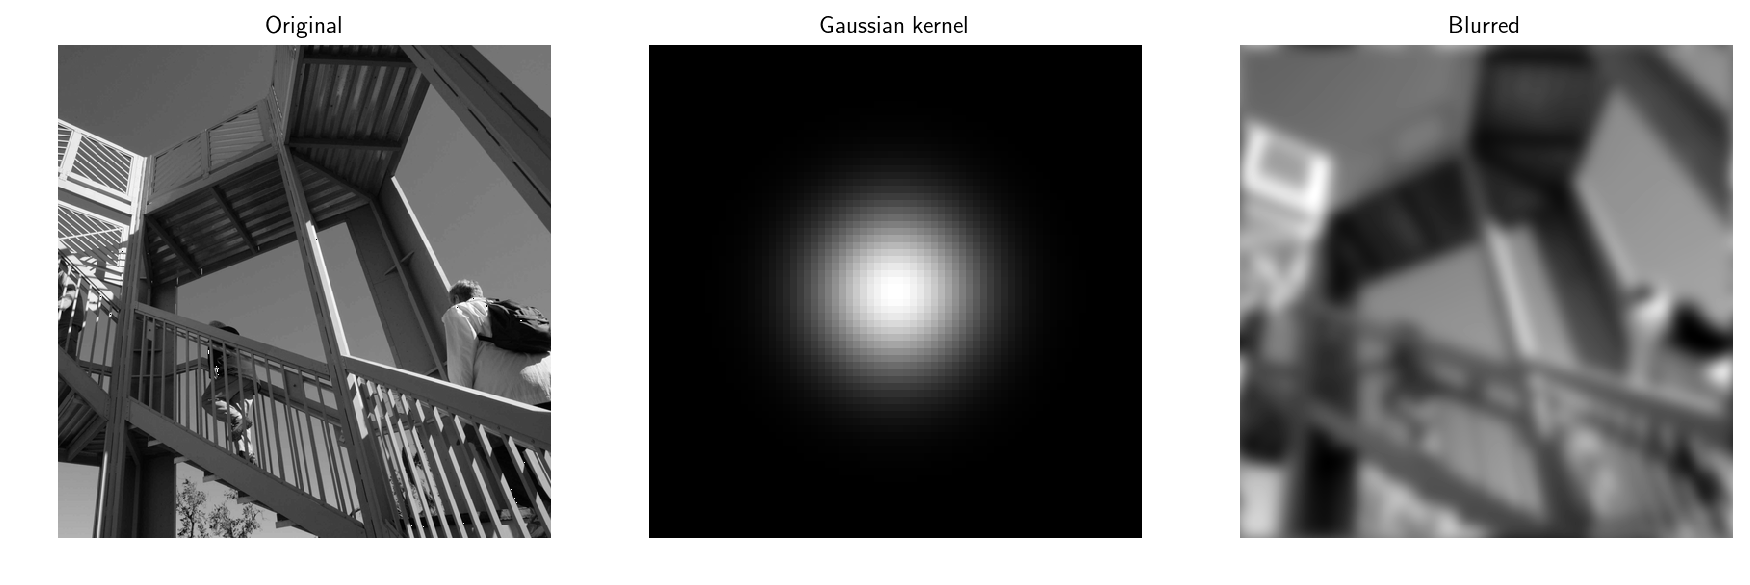

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, signal

def fftconvolve(x, y):
    dx, dy = x.shape[0], y.shape[0]
    y = np.pad(y, pad_width=[(0, dx - dy)] * 2, mode='constant')
    out = np.fft.ifft2(np.fft.fft2(x) * np.fft.fft2(y)).real
    return np.roll(out, (-((dy - 1) // 2), -((dy - 1) // 2)), axis=(0, 1))
    return out

data = misc.ascent()
kernel = np.outer(signal.gaussian(70, 8), signal.gaussian(70, 8))
scipy_blurred = signal.convolve2d(data, kernel, boundary='wrap', mode='same')
fft_blurred = fftconvolve(data, kernel)
assert np.allclose(scipy_blurred, fft_blurred)

%timeit signal.convolve2d(data, kernel, boundary='wrap', mode='same')
%timeit fftconvolve(data, kernel)
%timeit signal.fftconvolve(data, kernel)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(data, cmap='gray')
axes[0].set_title('Original')
axes[0].set_axis_off()
axes[1].imshow(kernel, cmap='gray')
axes[1].set_title('Gaussian kernel')
axes[1].set_axis_off()
axes[2].imshow(fft_blurred, cmap='gray')
axes[2].set_title('Blurred')
axes[2].set_axis_off();

Our implementation of the 2D convolution is 150 times faster than SciPy's implementation that does not make use of FFT, which is very impressive!

### Circulant Matrix

A circular convolution of two sequences $c = (c_0, c_1, \dots, c_{n - 1})$ and $x = (x_0, x_1, \dots, x_{n - 1})$ is equivalent to a matrix-vector multiplication $c * x = Cx$ where $C$ is a circulant matrix:
\\[ C = \begin{bmatrix} c_0 & c_1 & \dots & c_{n - 1} \\ c_{n - 1} & c_0 & \dots & c_{n - 2} \\ \vdots & \vdots & \ddots & \vdots \\ c_{1} & c_2 & \dots c_{n - 1} & c_0 \end{bmatrix}.\\]
Let $f_k$ be the $k$-column of the DFT matrix $F_n$. The convolution theorem implies that
\\[ Cf_k = c * f_k = F_n^{-1}((F_n c) \cdot (F_n f_k)) = \frac{1}{n} F_n ((F_n c) \cdot (ne_k)) = (f_k^{\mathsf{T}} c) f_k.\\]
In other words, $f_k$ is an eigenvector of $C$. More generally, the columns of the DFT matrix are precisely the eigenvectors of $C$, and those eigenvectors are the same for all circulant matrices! The eigenvalues of $C$ are given by the diagonal matrix $\text{diag}(F_n c)$, which of course depend on $c$. Since $C = F_n^{-1} \text{diag}(F_n c) F_n$, we can multiply $Cx$ in $\mathcal{O}(n \log{n})$ time:

In [5]:
import numpy as np
import scipy

def circulant_matvec(c, x):
    return np.fft.ifft(np.fft.fft(c) * np.fft.fft(x))

c = np.random.rand(4096)
x = np.random.rand(4096)
C = scipy.linalg.circulant(c)
assert np.allclose(np.dot(C, x), circulant_matvec(c, x))
%timeit np.dot(C, x)
%timeit circulant_matvec(c, x)

5.97 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
298 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [2]:
from IPython.core.display import HTML
css_file = './custom/custom.css'
HTML(open(css_file, "r").read())